In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
words = open("data/names.txt").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# create encoder/decoder
chars = list(set("".join(words)))
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi["."]=0
itos = {v:k for k,v in stoi.items()}
vocab_size = len(stoi)
vocab_size

27

In [4]:
# build dataset
block_size = 3

def build_dataset(words:list[str]):
    x, y = [], []
    for word in words:
            
        ctx = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            x.append(ctx)
            y.append(ix)
            ctx = ctx[1:] + [ix]

    x = torch.tensor(x)
    y = torch.tensor(y)

    return x,y

In [5]:
# split dataset
import random 

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte= build_dataset(words[n2:])
xtr.shape, xdev.shape, xte.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [ ]:
# build model

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd, generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden, generator=g) * (5/3)/((n_embd*block_size)**0.5) # kaiming initialization
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0 

bngain = torch.ones((1,n_hidden))
bnbais = torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1,n_hidden)) # we will keep track of bnmean and bnstd to use it in inference time
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, b1, W2, b2]
print("Number of Elements: ",sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

Number of Elements:  11897


In [ ]:
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, xtr.shape[0], (batch_size,), generator=g)
    xb, yb = xtr[ix], ytr[ix]

    emb = C[xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True) # in formula( x - mean(x) / sqrt(var(x) + epsilon)) where we use epsilon incase if the variance is zero it will not infinity/error
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbais

    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001 # 0.001 is the momentum; if the batch size higher we should increase it; because for higer batch size the mean and std will mostly same
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data = p.data - lr*p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.item())
    break


      0/  20000: 3.296529


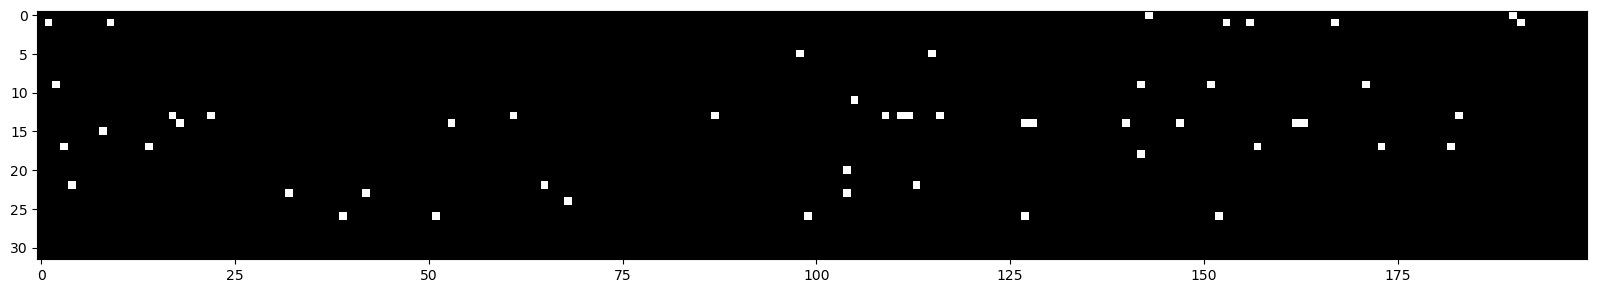

In [56]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>.99, cmap='gray', interpolation='nearest')

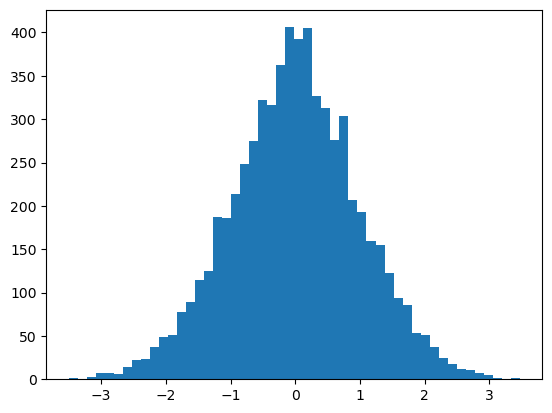

In [58]:
plt.hist(hpreact.view(-1).tolist(), 50)
plt.show()

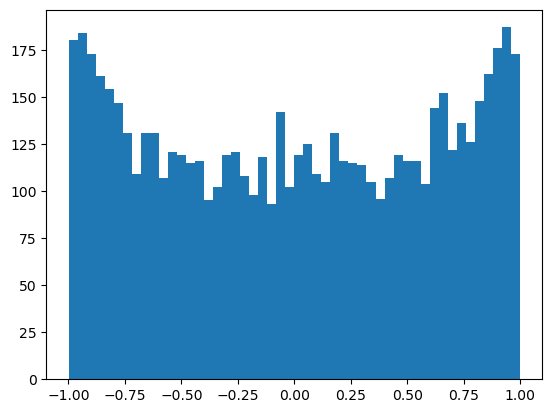

In [59]:
plt.hist(h.view(-1).tolist(), 50)
plt.show()

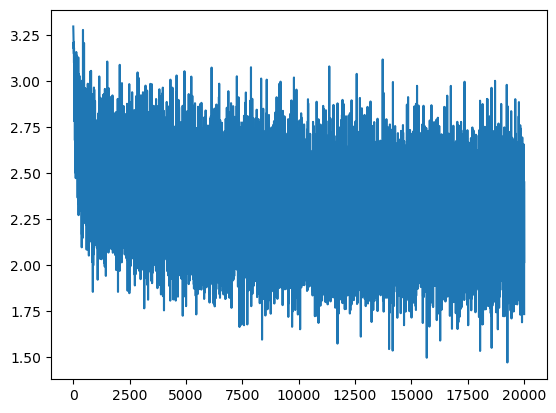

In [33]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train":(xtr,ytr),
        "test": (xte,yte),
        "val" : (xdev,ydev)
    }[split]

    emb=C[x]
    embcat= emb.view(emb.shape[0],-1)
    hpreact= embcat @ W1 # + b1  # b1 is useless because after taking mean and then subtracting it from hpreact will make it's grad 0
    hpreact = bngain * (hpreact-bnmean_running)/ bnstd_running + bnbais
    h= torch.tanh(hpreact)
    logits= h @ W2 + b2
    loss = F.cross_entropy(logits,y)

    print(split,loss.item())

In [72]:
split_loss('train')
split_loss('test')
split_loss('val')

train 3.2748405933380127
test 3.275351047515869
val 3.2754223346710205


In [ ]:
# explicit way to calculate bnmean and bnstd
with torch.no_grad():
    emb = C[xtr]
    hpreact = emb.view(emb.shape[0],-1) @ W1 + b1
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

In [ ]:
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    ctx = [0] * block_size
    while True:
        emb = C[torch.tensor(ctx)]
        embcat = emb.view(1,-1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbais
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        ctx = ctx[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join([itos[ix] for ix in out]))



zohnasmina.
siol.
ergon.
kassie.
elmine.
xajsharmin.
kosza.
cisa.
alereinazarasour.
lyanno.
tas.
ell.
isa.
jabrlaria.
aarti.
finy.
nousskira.
mery.
nah.
laiy.


In [ ]:
-torch.tensor(1/50257).log() # initial loss of a random model with 50257 outputs

tensor(10.8249)

In [27]:
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[0].log()
logits, probs, loss

(tensor([ 10.8306, -13.1794,  19.0042,   5.1154]),
 tensor([2.8193e-04, 1.0538e-14, 9.9972e-01, 9.2914e-07]),
 tensor(8.1738))